# Import packages

In [1]:
import torch
import torch.nn as nn
import torchdiffeq
from torchdiffeq import odeint
from xitorch.interpolate import Interp1D
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

# Define classes for parameter-container and sequence generator

In [2]:
"""
Class RateStateParams, manages data of rate-and-state friction with flash-heating effect, contains 
    Data:
        fr: Reference friction coefficient
        a: Rate-and-state parameter a
        b: Rate-and-state parameter b
        DRS: Characteristic slip distance
        Vw: Flash-heating slip rate
        fw: Flash-heating friction coefficient
        
"""
class RateStateParams:
    # Constructor
    def __init__(self, fr = 0.6, Vr = 1.e-6, a = 0.016, b = 0.011, DRS = 1.e-6, Vw = 1.0e6, fw = 0.2):
        self.fr = fr
        self.Vr = Vr
        self.a = a
        self.b = b
        self.DRS = DRS
        self.Vw = Vw
        self.fw = fw
        
    # Output the information of this class
    def print_info(self):
        print("-" * 20, " Rate-and-state parameters ", "-"*20)
        print('fr:       ', self.fr)
        print('a:        ', self.a)
        print('b:        ', self.b)
        print('Vr:       ', self.Vr)
        print('DRS:      ', self.DRS)
        print('Vw:       ', self.Vw)
        print('fw:       ', self.fw)
        

In [6]:
"""
Class TimeSequenceGen, container for a Generated time sequence containing 
    Data:
        t [number of time points]: Tensor for time stamps, prescribed
        N [number of time points]: Tensor for normal stress, prescribed
        Ds [number of time points]: Tensor for slip rate, prescribed
        s [number of time points]: Tensor for slip, prescribed
        theta [number of hidden variables, number of time points]: Tensor for hidden variables, computed
        params : Class for parameters
   
    Method:
        __init__ : Constructor
        DthetaDt : Evolution function for hidden variables theta
        calTau : Calculate the function of shear stress Tau
        
"""
class TimeSequenceGen:
    # Constructor
    def __init__(self, t, N, Ds, params):
        # Load the parameters
        self.t = t
        self.N = N
        self.Ds = Ds
        self.s = torch.zeros(Ds.shape, dtype = torch.float64)
        self.s[:, 1:] = torch.cumulative_trapezoid(Ds, x = t)
        self.params = params
        
        # Calculate theta history
        self.theta = torch.zeros(Ds.shape, dtype = torch.float64)
        
        # Compute the interpolation for slip rate Ds
        self.t_temp = torch.concat([self.t, torch.tensor([self.t[-1] + 1.0])], 0)
        self.Ds_temp = torch.concat([self.Ds, self.Ds[:, -1].reshape([-1, 1])], 1)
        self.DsAtT = interp1d(self.t_temp, self.Ds_temp, kind="cubic")
        
        # Evolve theta(t)
        self.theta = torch.transpose(self.calTheta(), 0, 1)

        # Finish computing tau
        self.tau = self.calTau()
    
    # Function DthetaDt, defines DthetaDt as a function of temporally local values
    def DthetaDt(self, t, theta):
        # print('t = ', t)
        DthetaDt = 1. - (torch.tensor(self.DsAtT(t)) * theta / self.params.DRS)
        return DthetaDt
    
    # Function calTau, calculates shear traction tau, suingregularized rate-and-state formulation
    def calTau(self):
        # Set aliases for rate-and-state parameters
        a = self.params.a
        b = self.params.b
        Vr = self.params.Vr
        DRS = self.params.DRS
        fr = self.params.fr
        
        tau = self.N * a * torch.asinh(
                   self.Ds / 2. / Vr * torch.exp((fr + b * torch.log(Vr * self.theta / DRS)) / a)
                   )
        return tau
    
    # Calculate theta using s(t), Ds(t), theta(t) and params
    def calTheta(self, theta0 = 1.0):
        theta = odeint(self.DthetaDt, theta0 * torch.ones(self.Ds.shape[0], dtype = torch.float64), self.t, 
                       rtol = 1.e-10, atol = 1.e-12, method = 'dopri8')
        return theta
    
# Define the function to run in parallel
def getSTauAndTheta(t, N, V, params):
    mySeq = TimeSequenceGen(t, N, V, params)
    return mySeq.s, mySeq.tau, mySeq.theta


# Demo: given $N(t)$ and $V(t)$, generate $\theta(t)$ and $\tau(t)$

In [11]:
# Set parameters
RSparams = RateStateParams()
RSparams.print_info()

--------------------  Rate-and-state parameters  --------------------
fr:        0.6
a:         0.016
b:         0.011
Vr:        1e-06
DRS:       1e-06
Vw:        1000000.0
fw:        0.2


In [27]:
# Load t [s], N(t) [MPa]
import scipy.io
import time
# Load slip rate from .mat file
mat = scipy.io.loadmat('./data/realDatas.mat')
Vsave = torch.from_numpy(mat['Vsave']).double()
Nsave = torch.from_numpy(mat['Nsave']).double()
t = torch.from_numpy(mat['Time'][0]).double()


# Generate theta(t) and tau(t)
st_time = time.time()
sReal, tauReal, thetaReal = getSTauAndTheta(t, Nsave, Vsave, RSparams)
timeConsumed = time.time() - st_time
print('Time consumed (single core): ', timeConsumed, ' s')

# Save to file
filename = './data/realDatas.pt'
indexes = torch.randperm(Nsave.shape[0])
seqObj = {'S' : sReal, 'N' : Nsave, 'V' : Vsave, 'tau' : tauReal, 'theta' : thetaReal, 
          't' : t, 'indexes' : indexes}
torch.save(seqObj, filename)


Time consumed (single core):  20.029746770858765  s


In [29]:
# Load from file
filename = "./data/realDatas.pt"
loaded = torch.load(filename)
indexes = loaded['indexes']
tauAll = loaded['tau'][indexes]
NAll = loaded['N'][indexes]
VAll = loaded['V'][indexes]
sAll = loaded['S'][indexes]
thetaAll = loaded['theta'][indexes]
t = loaded['t']


print('-' * 20, 'Data Info', '-' * 20)
print('Number of data lines: ', NAll.shape[0])
print('Number of time grid points: ', NAll.shape[1])

-------------------- Data Info --------------------
Number of data lines:  3737
Number of time grid points:  1000


Text(0.5, 0.98, 'The 200th sequence')

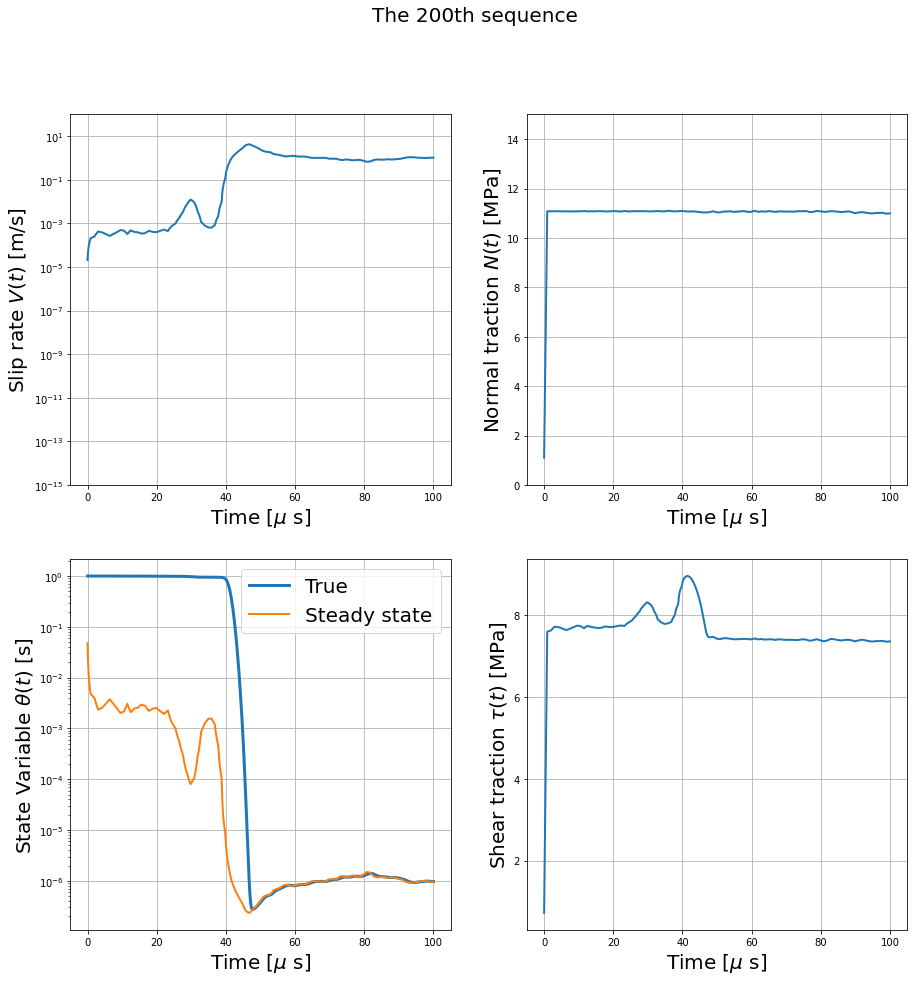

In [31]:
# Plot Sequence of V(t) and N(t) given sample-index
sample_idx = 200
f, axs = plt.subplots(2, 2, figsize = (15, 15))

# Plot V(t)
axs[0][0].semilogy(1e6 * t, VAll[sample_idx, :], linewidth=2.0)
axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
axs[0][0].set_ylim([1e-15, 1e2])
axs[0][0].grid()

# Plot N(t)
axs[0][1].plot(1e6 * t, NAll[sample_idx, :], linewidth=2.0)
axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][1].set_ylabel('Normal traction $N(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[0][1].set_ylim([0, 15])
axs[0][1].grid()
                
# Plot theta(t)
axs[1][0].semilogy(1e6 * t, thetaAll[sample_idx, :], linewidth=3.0)
axs[1][0].semilogy(1e6 * t, RSparams.DRS / VAll[sample_idx, :], linewidth=2.0)
axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
axs[1][0].legend(['True', 'Steady state'], loc='best', fontsize=20)
axs[1][0].grid()
                
# Plot \tau(t)
axs[1][1].plot(1e6 * t, tauAll[sample_idx, :], linewidth=2.0)
axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[1][1].grid()

f.suptitle("The " + str(sample_idx) + "th sequence", fontsize = 20)

# RNN for training

In [32]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU not available, CPU used


In [33]:
"""
Class RSRNN: Maps from X(t) = (N(t), V(t), S(t)) to tau(t)
   
"""
class RSRNN(nn.Module):
    
    # Constructor
    def __init__(self, input_size = 3, output_size = 1, hidden_dim = 1, n_layers = 1, isGRU = False):
        r"""
            Inputs: #-----------------------------------------------------------------------------------------
                input_size: dimension of input X(t)
                output_size: dimension of output tau(t)
                hidden_dim: dimension of hidden variables xi(t)
                n_layers: number of stacked RNN layers
        
        """
        
        # Call parent class constructor
        super(RSRNN, self).__init__()
        
        # Defining some parameters
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size = self.input_size, 
                          hidden_size = self.hidden_dim, 
                          num_layers = n_layers, 
                          batch_first = True)
        if isGRU:
            self.rnn = nn.GRU(input_size = self.input_size, 
                              hidden_size = self.hidden_dim, 
                              num_layers = n_layers, 
                              batch_first = True)
        
        # Fully connected layers, maps from (X(t), xi(t)) to tau(t)
        self.fc = nn.Sequential(
            nn.Linear(input_size + hidden_dim, 64), 
            nn.ReLU(), 
            nn.Linear(64, 64), 
            nn.ReLU(), 
            nn.Linear(64, output_size),
        )
    
    
    # Forward evaluation function
    def forward(self, x):
        r"""
            Inputs: #-----------------------------------------------------------------------------------------
                x [batch_size, sequence_length, input_size]: A batch of input sequences X([0, t])

            Outputs: #----------------------------------------------------------------------------------------
                out [batch_size, sequence_length, output_size]: The batch of output sequences tau([0, t])
                Hs [batch_size, sequence_length, hidden_dim]: The batch of hidden variables xi([0, t]), 
                    only on the last layer if n_layers is greater than 1.
            
        """
        # Get the batch_size, x is organized as [batch_size, sequence_length, input_size]
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        Hs, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        xAndH = torch.cat([x, Hs], 2)
        # xAndH_newView = xAndH.contiguous().view(-1, self.hidden_dim + self.input_size)
        
        # Get the output from (x, H)
        out = self.fc(xAndH)
        
        return out, Hs
    
    
    # Initialize the hidden variables xi(0)
    def init_hidden(self, batch_size):
        r"""
            Inputs: #-----------------------------------------------------------------------------------------
                batch_size
                
            Outputs: #-----------------------------------------------------------------------------------------
                hidden [n_layers, batch_size, hidden_dim]: Initialized hidden 
        """
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.ones([self.n_layers, batch_size, self.hidden_dim])
        return hidden

# Define loss functions

In [34]:
"""
Function AccessibleL2Loss, Calculate L2 loss in time for a sequence
    Inputs: #-----------------------------------------------------------------------------------------
        X [batch_size, n_grid_points]: A batch of predicted sequences
        X_true [batch_size, n_grid_points]: The batch of real sequences
        
    Outputs: #----------------------------------------------------------------------------------------
        L2Loss: |X - X_true|^2
        
"""
def AccessibleL2Loss(X, X_true, normalize = True):
    L2Loss = torch.sum(torch.square(X - X_true)) / X.shape[0]
    if normalize:
        L2Loss = L2Loss / X.shape[1]
    return L2Loss


# Set up a training example

In [66]:
# Dataloader
from torch.utils.data import TensorDataset, DataLoader
logVFlag = True

# Data set contains ([N(t), V(t), S(t)]; [theta(t), tau(t)])
XAll = torch.stack([NAll, VAll, sAll], 2)

# Turn input into logV
if logVFlag:
    XAll = torch.stack([NAll, torch.log10(VAll), sAll], 2)

print('XAll shape: ', XAll.shape)

AllData = TensorDataset(
    XAll.float(),
    thetaAll.reshape([thetaAll.shape[0], thetaAll.shape[1], 1]).float(),
    tauAll.reshape([thetaAll.shape[0], thetaAll.shape[1], 1]).float(),
)

# Training-testing separation
trainSetLen = int(len(AllData) * 0.8)
testSetLen = len(AllData) - trainSetLen

# Separate the data set
# trainDataSet, testDataSet = torch.utils.data.random_split(AllData, [trainSetLen, testSetLen])
trainDataSet = torch.utils.data.Subset(AllData, range(0, trainSetLen))
testDataSet = torch.utils.data.Subset(AllData, range(trainSetLen, testSetLen + trainSetLen))
print('Training data set length: ', len(trainDataSet))
print('Testing data set length: ', len(testDataSet))

# Training data loader
training_batch_size = 256
trainDataLoader = DataLoader(
    trainDataSet,
    batch_size = training_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    pin_memory = False,
)

# Testing data loader
testing_batch_size = 64
testDataLoader = DataLoader(
    testDataSet,
    batch_size = testing_batch_size,
    shuffle = True,
#    num_workers = 16,
    collate_fn = None,
    pin_memory = False,
)


# Initialize the RNN 
model = RSRNN(n_layers=1, isGRU = False)

# Learning rate
learning_rate = 1.0e-3

# Optimizer SGD
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)


XAll shape:  torch.Size([3737, 1000, 3])
Training data set length:  2989
Testing data set length:  748


In [69]:
tauPred = model(XAll.float())
loss = AccessibleL2Loss(tauPred[0], tauAll.reshape([thetaAll.shape[0], thetaAll.shape[1], 1]).float())

In [64]:
torch.sum(~XAll.isnan())

tensor(11211000)

In [68]:
torch.sum(XAll.float().isnan())

tensor(0)

In [73]:
torch.sum(tauPred[0].isnan(), 1)

tensor([[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]])

In [76]:
torch.sum(torch.any(tauPred[0].isnan(), 1))

tensor(385)

In [46]:
# Function train1Epoch
def train1Epoch(dataloader, loss_fn, model, optimizer):
    r"""
        Inputs: # --------------------------------------------------------------------------------------------
            dataloader: training data set loader
            loss_fn: loss function
            model: the RNN model being trained
            optimizer: handle to the optimizer
            
        Outputs: # -------------------------------------------------------------------------------------------
            loss: Training loss at the current data set
    
    """
    losses = []
    for idx, (X, theta, tau) in enumerate(dataloader):
        
#         # DEBUG LINES
#         print('X shape: ', X.shape)
#         print('theta shape: ', theta.shape)
#         print('tau shape: ', tau.shape)
        
        optimizer.zero_grad()
        out, Hs = model(X)
        loss = loss_fn(tau, out)
        
#         # DEBUG LINES
#         print('loss of batch ', idx, ': ', loss)
        
        loss.backward()
        optimizer.step()
        losses.append(loss * X.shape[0])
    
    # Return the avg loss for each sequence
    return sum(losses) / len(dataloader.dataset)


# Function evaluate test loss
def evaluateTestLoss(dataloader, loss_fn, model):
    r"""
        Inputs: # --------------------------------------------------------------------------------------------
            dataloader: testing data set loader
            loss_fn: loss function
            model: the RNN model being trained
            
        Outputs: # -------------------------------------------------------------------------------------------
            loss: Testing loss at the current data set
    
    """
    losses = []
    for idx, (X, theta, tau) in enumerate(dataloader):
        out, Hs = model(X)
        loss = loss_fn(tau, out)
        losses.append(loss * X.shape[0])
    
    # Return the avg loss for each sequence
    return sum(losses) / len(dataloader.dataset)

In [47]:
import time
# Train for 100 epochs
model_save_path = './data/model_realDatas_gru_1015.pth'
loss_save_path = './data/loss_realDatas_gru_1015.pt'
loss_history_train = []
loss_history_test = []

# Number of epochs
n_epochs = 100
output_freq = 1

# Learning rate
learning_rate = 1.0e-3

# Optimizer SGD
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

for epoch in range(n_epochs):
    st_time = time.time()
    
    # Train for 1 epoch
    train_loss = train1Epoch(trainDataLoader, AccessibleL2Loss, model, optimizer)
    loss_history_train.append(train_loss.item())
    
    # Track training time
    epoch_time = time.time() - st_time
    
    # Evaluate test loss
    test_loss = evaluateTestLoss(testDataLoader, AccessibleL2Loss, model)
    loss_history_test.append(test_loss.item())
    
    # Print out information
    if epoch % output_freq == 0:
        print("-"*20, " Epoch ", epoch, "-"*20)
        print("Training loss: ", train_loss)
        print("Testing loss: ", test_loss)
        print("Training time for this epoch: ", epoch_time)
        print('\n')

# Save the trained model
LossObj = {'train_loss' : loss_history_train, 'test_loss' : loss_history_test}
torch.save(model, model_save_path)
torch.save(LossObj, loss_save_path)


--------------------  Epoch  0 --------------------
Training loss:  tensor(nan, grad_fn=<DivBackward0>)
Testing loss:  tensor(nan, grad_fn=<DivBackward0>)
Training time for this epoch:  2.6617369651794434


--------------------  Epoch  1 --------------------
Training loss:  tensor(nan, grad_fn=<DivBackward0>)
Testing loss:  tensor(nan, grad_fn=<DivBackward0>)
Training time for this epoch:  2.6592178344726562


--------------------  Epoch  2 --------------------
Training loss:  tensor(nan, grad_fn=<DivBackward0>)
Testing loss:  tensor(nan, grad_fn=<DivBackward0>)
Training time for this epoch:  2.606980562210083




KeyboardInterrupt: 

# Load model, plot predictions

Text(0.5, 1.0, 'Training with 1 hidden variable')

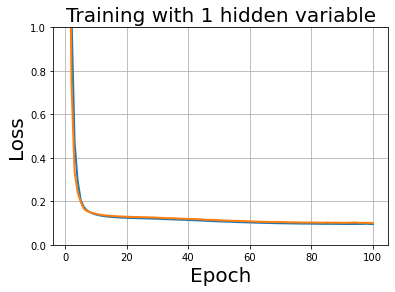

In [252]:
# Paths
model_save_path = './data/model_10000_logV_1014_seq3_gru.pth'
loss_save_path = './data/loss_10000_logV_1014_seq3_gru.pt'
trainedModel = torch.load(model_save_path)
loadedHistory = torch.load(loss_save_path)

loss_history_train = loadedHistory['train_loss']
loss_history_test = loadedHistory['test_loss']

# Plot loss-epoch curve
plt.plot(range(1, 1 + len(loss_history_train)), loss_history_train, linewidth = 2.0)
plt.plot(range(1, 1 + len(loss_history_test)), loss_history_test, linewidth = 2.0)
plt.grid()

plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Loss', fontsize = 20)
plt.ylim([0, 1])
plt.title('Training with 1 hidden variable', fontsize = 20)


Text(0.5, 0.98, 'The 1000th sequence')

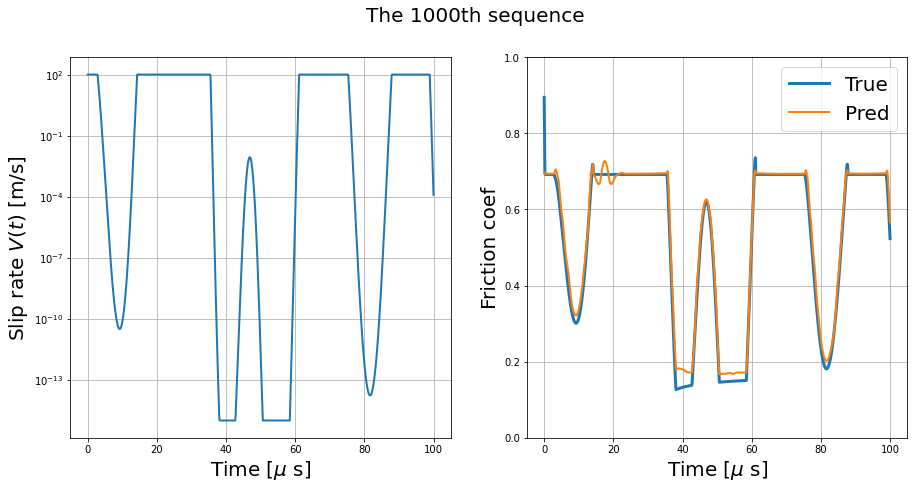

In [253]:
# Plot the slip rate, friction coefficient vs. time for sequence [idx]
idx = 1000
f, axs = plt.subplots(1, 2, figsize = (15, 7))
XAll_test = XAll[testDataSet.indices].float()
VAll_test = VAll[testDataSet.indices].float()
thetaAll_test = thetaAll[testDataSet.indices].float()
NAll_test = NAll[testDataSet.indices].float()
sAll_test = sAll[testDataSet.indices].float()

tauAll_test_true = tauAll[testDataSet.indices].float()
tauAll_test_pred, hiddenAll_test_pred = trainedModel(XAll_test)
tauAll_test_pred = tauAll_test_pred.reshape([tauAll_test_pred.shape[0], XAll_test.shape[1]]).detach()
fcoef_test_true = tauAll_test_true / NAll_test
fcoef_test_pred = tauAll_test_pred / NAll_test

# Plot V(t)
axs[0].semilogy(1e6 * t, VAll_test[idx, :], linewidth=2.0)
axs[0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
# axs[0].set_ylim([1e-6, 1e2])
axs[0].grid()
                
# Plot fcoef(t)
# axs[1].scatter(1e6 * t, fcoef_test_true[idx, :])
axs[1].plot(1e6 * t, fcoef_test_true[idx, :], linewidth=3.0)
axs[1].plot(1e6 * t, fcoef_test_pred[idx, :], linewidth=2.0)
axs[1].legend(['True', 'Pred'], loc = 'best', fontsize = 20)
axs[1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1].set_ylabel('Friction coef', fontsize=20)
axs[1].set_ylim([0, 1])
axs[1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)

Text(0.5, 0.98, 'The 200th sequence')

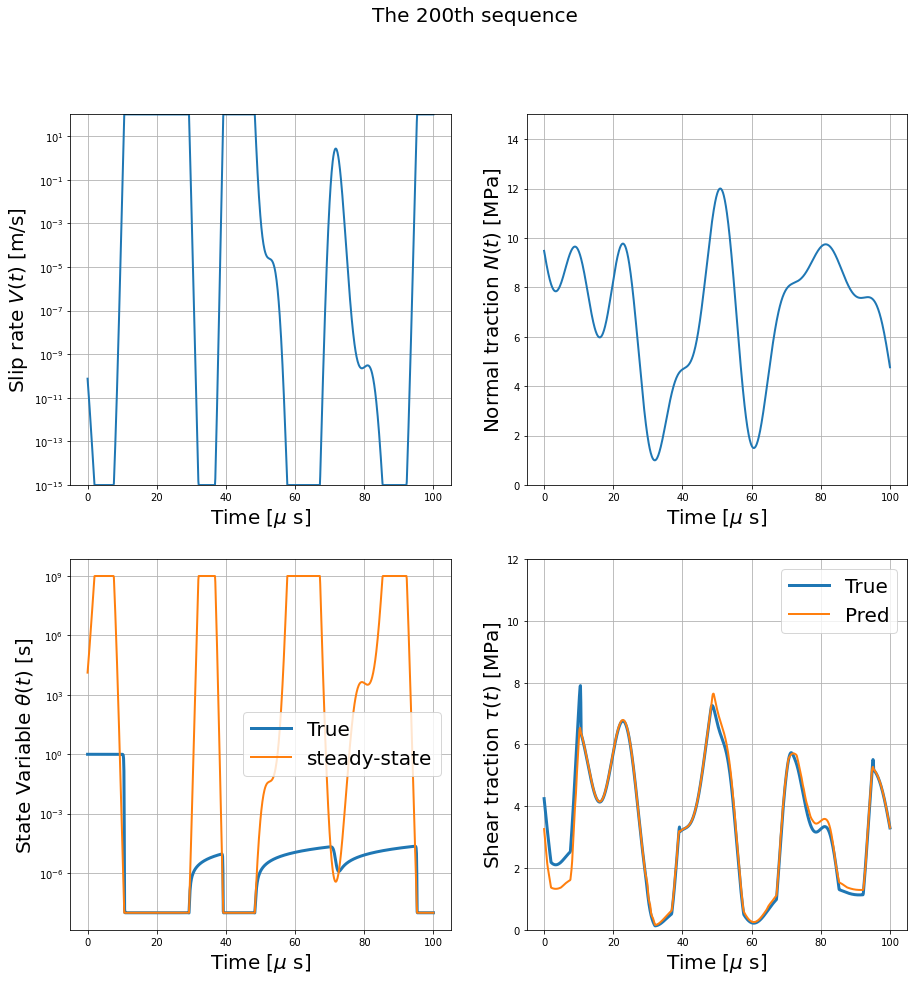

In [254]:
# Plot the V(t), N(t), theta(t), tau(t) for sequence [idx]
idx = 200
f, axs = plt.subplots(2, 2, figsize = (15, 15))

# Plot V(t)
axs[0][0].semilogy(1e6 * t, VAll_test[idx, :], linewidth=2.0)
axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
axs[0][0].set_ylim([1e-15, 1e2])
axs[0][0].grid()

# Plot N(t)
axs[0][1].plot(1e6 * t, NAll_test[idx, :], linewidth=2.0)
axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][1].set_ylabel('Normal traction $N(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[0][1].set_ylim([0, 15])
axs[0][1].grid()
                
# Plot theta(t)
axs[1][0].semilogy(1e6 * t, thetaAll_test[idx, :], linewidth=3.0)
axs[1][0].semilogy(1e6 * t, 1.e-6 / VAll_test[idx, :], linewidth=2.0)
axs[1][0].legend(['True', 'steady-state'], loc='best', fontsize = 20)
axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
axs[1][0].grid()
                
# Plot \tau(t)
axs[1][1].plot(1e6 * t, tauAll_test_true[idx, :], linewidth=3.0)
axs[1][1].plot(1e6 * t, tauAll_test_pred[idx, :], linewidth=2.0)
axs[1][1].legend(['True', 'Pred'], loc = 'best', fontsize = 20)
axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[1][1].set_ylim([0, 12])
axs[1][1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)

# Test on a real slip-rate-sequence obtained from FEM simulation

In [255]:
import scipy.io
import time
# Load slip rate from .mat file
mat = scipy.io.loadmat('./data/realData.mat')
V = torch.from_numpy(mat['QueryV']).double()
N = -torch.from_numpy(mat['QueryNormalStress']).double() / 1.e6
N[:, 0] = 10.939

timeVN = torch.from_numpy(mat['time'][0]).double()

# Re-cast to [0, 100 \mu s]
T = 100.e-6
N_grid_points = 1_000
t = torch.linspace(0., T, N_grid_points, dtype = torch.float64)
interpV = interp1d(timeVN, V)
interpN = interp1d(timeVN, N)

# Get real-data V and N sequences
VrealTest = torch.from_numpy(interpV(t))
NrealTest = torch.from_numpy(interpN(t))

# Generate theta(t) and tau(t)
st_time = time.time()
sReal, tauReal, thetaReal = getSTauAndTheta(t, NrealTest, VrealTest, RSparams)
timeConsumed = time.time() - st_time
print('Time consumed (single core): ', timeConsumed, ' s')

# Save to file
filename = './data/realData.pt'
seqObj = {'S' : sReal, 'N' : NrealTest, 'V' : VrealTest, 'tau' : tauReal, 'theta' : thetaReal, 't' : t}
torch.save(seqObj, filename)

Time consumed (single core):  3.571784257888794  s


In [256]:
# Get RNN prediction from trained model
model_save_path = './data/model_10000_logV_1014_seq3_gru.pth'
trainedModel = torch.load(model_save_path)
XReal = torch.stack([NrealTest, torch.log10(VrealTest), sReal], 2).float()
tauReal_pred, hiddenReal_pred = trainedModel(XReal)
tauReal_pred = tauReal_pred.reshape([tauReal_pred.shape[0], tauReal_pred.shape[1]]).detach()

# Plot real data set predictions

Text(0.5, 0.98, 'The 2th sequence')

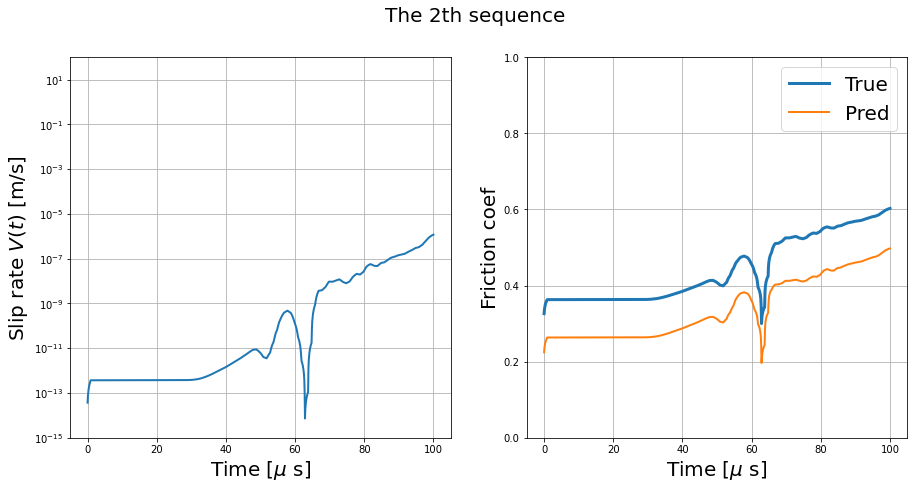

In [257]:
# Plot the slip rate, friction coefficient vs. time for sequence [idx]
idx = 0
f, axs = plt.subplots(1, 2, figsize = (15, 7))

# Plot V(t)
axs[0].semilogy(1e6 * t, VrealTest[idx, :], linewidth=2.0)
axs[0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
axs[0].set_ylim([1e-15, 1e2])
axs[0].grid()

fcoef_real_true = tauReal / NrealTest
fcoef_real_pred = tauReal_pred / NrealTest
                
# Plot fcoef(t)
axs[1].plot(1e6 * t, fcoef_real_true[idx, :], linewidth=3.0)
axs[1].plot(1e6 * t, fcoef_real_pred[idx, :], linewidth=2.0)
axs[1].legend(['True', 'Pred'], loc = 'best', fontsize = 20)
axs[1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1].set_ylabel('Friction coef', fontsize=20)
axs[1].set_ylim([0, 1])
axs[1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)

Text(0.5, 0.98, 'The 0th sequence')

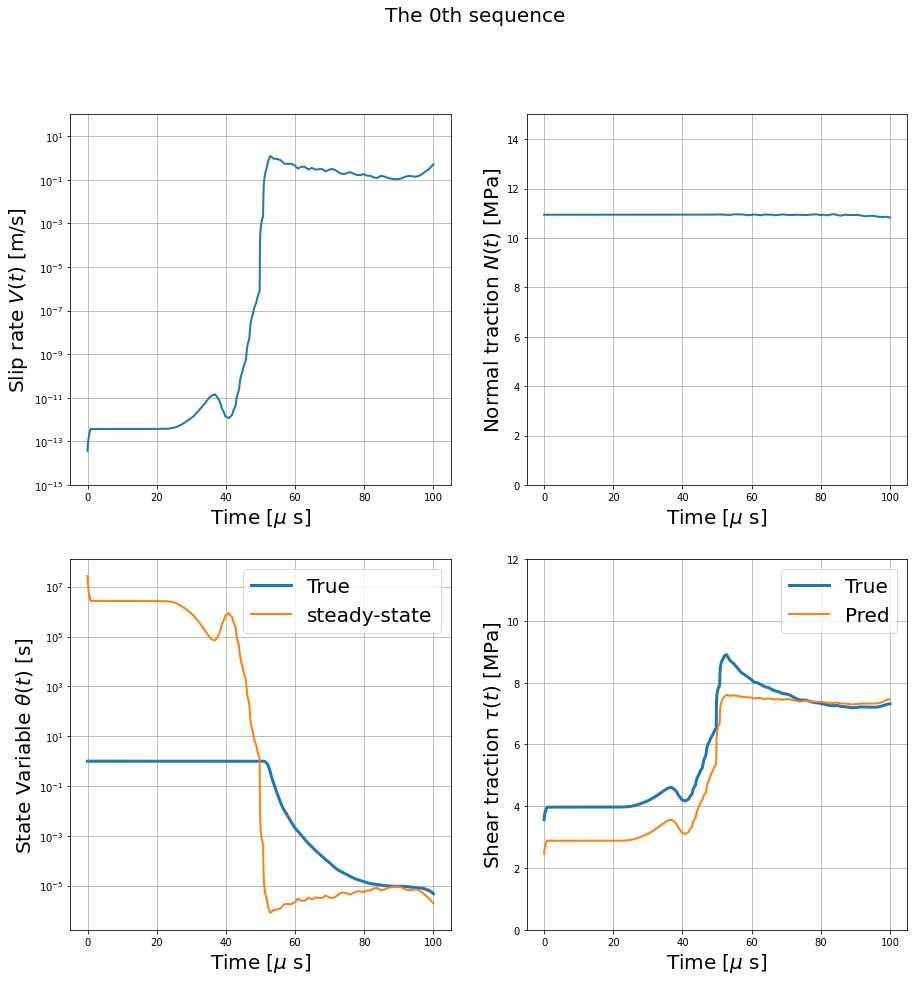

In [260]:
# Plot the V(t), N(t), theta(t), tau(t) for sequence [idx]
idx = 0
f, axs = plt.subplots(2, 2, figsize = (15, 15))

# Plot V(t)
axs[0][0].semilogy(1e6 * t, VrealTest[idx, :], linewidth=2.0)
axs[0][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][0].set_ylabel('Slip rate $V(t)\  \mathrm{[m/s]}$', fontsize=20)
axs[0][0].set_ylim([1e-15, 1e2])
axs[0][0].grid()

# Plot N(t)
axs[0][1].plot(1e6 * t, NrealTest[idx, :], linewidth=2.0)
axs[0][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[0][1].set_ylabel('Normal traction $N(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[0][1].set_ylim([0, 15])
axs[0][1].grid()
                
# Plot theta(t)
axs[1][0].semilogy(1e6 * t, thetaReal[idx, :], linewidth=3.0)
axs[1][0].semilogy(1e6 * t, 1.e-6 / VrealTest[idx, :], linewidth=2.0)
axs[1][0].legend(['True', 'steady-state'], loc='best', fontsize = 20)
axs[1][0].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][0].set_ylabel('State Variable $\\theta(t)\ \mathrm{[s]}$', fontsize=20)
axs[1][0].grid()
                
# Plot \tau(t)
axs[1][1].plot(1e6 * t, tauReal[idx, :], linewidth=3.0)
axs[1][1].plot(1e6 * t, tauReal_pred[idx, :], linewidth=2.0)
axs[1][1].legend(['True', 'Pred'], loc = 'best', fontsize = 20)
axs[1][1].set_xlabel('Time [$\mu$ s]', fontsize=20)
axs[1][1].set_ylabel('Shear traction $\\tau(t)\ \mathrm{[MPa]}$', fontsize=20)
axs[1][1].set_ylim([0, 12])
axs[1][1].grid()

f.suptitle("The " + str(idx) + "th sequence", fontsize = 20)